# Numerical Benchmarks

In [3]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Check Convergence

### Overparameterization

In [2]:
n = 3
d = 2**n
num_reps = 10
num_iter = 4000

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)

rank = 3
loss_values = np.zeros((num_iter, num_reps))
c_values = np.zeros((num_iter, num_reps))


for i in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)

    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    c = random.uniform(0,1)
    kraus_model = KrausMap(
                       U=U, 
                       c=c, 
                       d=d, 
                       rank=d**2-1
                      )

    model = ModelQuantumMap(
                           q_map = kraus_model,
                           loss = probs_loss,
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs,
                targets = targets,
                inputs_val = None,
                targets_val = [kraus_target],
                num_iter = num_iter,
                N = 500,
                verbose = False,
                )
    
    loss_values[:, i] = np.array(model.loss_list)
    c_values[:, i] = np.array(model.c_list)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [3]:
data = [loss_values, c_values]
pickle.dump(data, open("../../data/compressed_sensing_overparam.p", "wb"))

### Under-parameterization

In [15]:
n = 3
d = 2**n
num_reps = 10
num_iter = 4000

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)

rank = 3
loss_values = np.zeros((num_iter, num_reps))
c_values = np.zeros((num_iter, num_reps))


for i in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank=7)

    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    c = random.uniform(0,1)
    kraus_model = KrausMap(
                       U=U, 
                       c=c, 
                       d=d, 
                       rank=rank
                      )

    model = ModelQuantumMap(
                           q_map = kraus_model,
                           loss = probs_loss,
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs,
                targets = targets,
                inputs_val = None,
                targets_val = [kraus_target],
                num_iter = num_iter,
                N = 500,
                verbose = False,
                )
    
    loss_values[:, i] = np.array(model.loss_list)
    c_values[:, i] = np.array(model.c_list)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
data = [loss_values, c_values]
pickle.dump(data, open("../../data/compressed_sensing_underparam.p", "wb"))

## Sparse Input
### Generate Data

In [6]:
np.random.seed(42)
random.seed(42)

N_list = [int(16*2**(i/4)) for i in range(21)]
num_reps = 10

### Low Rank

In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 3

prior_fidelity = np.zeros((len(N_list), num_reps))
noPrior_fidelity = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
data = [prior_fidelity, noPrior_fidelity]
pickle.dump(data, open("../../data/compressed_sensing_rank4.p", "wb"))

### Medium Rank

In [9]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 7

prior_fidelity2 = np.zeros((len(N_list), num_reps))
noPrior_fidelity2 = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity2[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity2[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
data = [prior_fidelity2, noPrior_fidelity2]
pickle.dump(data, open("../../data/compressed_sensing_rank8.p", "wb"))

### High Rank

In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 15

prior_fidelity3 = np.zeros((len(N_list), num_reps))
noPrior_fidelity3 = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity3[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity3[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
data = [prior_fidelity3, noPrior_fidelity3]
pickle.dump(data, open("../../data/compressed_sensing_rank16.p", "wb"))

## Collapse of SPAM optimization

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 2
d = 2**n
rank = d

spam_target = SPAM(d=d, 
                   init = "ideal",
                   povm = "ideal",
                   )

### Generate Synthetic Data

In [6]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

### Fit SPAM model, no Pre-Training

In [7]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(d=d,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                 )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.8921902649442504
1 0.8791598613811485
2 0.8664378444021044
3 0.8540343076056153
4 0.8419629923787567
5 0.8302745546766239
6 0.8189254316461283
7 0.8079260217838797
8 0.797328867453269
9 0.7870964791473015
10 0.777252467281691
11 0.7678012329386679
12 0.7587422764817365
13 0.7500702533673002
14 0.7417746797010677
15 0.7338403029673441
16 0.7262488917928419
17 0.7189027999203573
18 0.7119036809497677
19 0.7051607061504508
20 0.698659058733764
21 0.6923715001368348
22 0.686269955117023
23 0.6803124724279446
24 0.6744751479178335
25 0.6685125168635264
26 0.6625511847186242
27 0.6565805147614103
28 0.6505763580483962
29 0.6445173936169589
30 0.6383315697365317
31 0.6320002069949808
32 0.6255589484899267
33 0.6190020285950987
34 0.6123305431961066
35 0.6055321927646852
36 0.5985269314117969
37 0.5914369933423573
38 0.584354221313732
39 0.5772045325834525
40 0.5699881035740305
41 0.5626968709831999
42 0.5553200487824674
43 0.5479018421513429
44 0.5406513321294365
45 0.5333543059059592
46 

348 0.0015876286600823154
349 0.0015708913235540818
350 0.0015543946231788024
351 0.0015381343414898033
352 0.001522106365904954
353 0.0015063066799949558
354 0.0014907313551195392
355 0.0014753765424396434
356 0.001460238465348555
357 0.0014453134123963915
358 0.001430597730811323
359 0.0014160878207449149
360 0.0014017801303755812
361 0.0013876711520023146
362 0.0013737574192336178
363 0.0013600355053461927
364 0.0013465020228343465
365 0.0013331536241198115
366 0.0013199870033330794
367 0.0013069988990203857
368 0.0012941860975886942
369 0.0012815454372639462
370 0.0012690738123173487
371 0.0012567681773128726
372 0.0012446255511396867
373 0.0012326430206174334
374 0.001220817743504387
375 0.0012091469507725275
376 0.001197627948074157
377 0.0011862581163608614
378 0.0011750349116642143
379 0.0011639558640857517
380 0.0011530185760675307
381 0.001142220720039083
382 0.0011315600355436058
383 0.0011210343259504705
384 0.0011106414548597173
385 0.0011003793422912208
386 0.001090245960

666 0.00017268636408901812
667 0.00017183802017576688
668 0.00017099513491612738
669 0.000170157664047628
670 0.00016932556374858848
671 0.00016849879063978522
672 0.00016767730178572472
673 0.0001668610546942527
674 0.0001660500073155265
675 0.0001652441180389652
676 0.00016444334568941544
677 0.00016364764952132111
678 0.0001628569892120496
679 0.0001620713248538926
680 0.00016129061694522038
681 0.00016051482638076699
682 0.0001597439144416271
683 0.00015897784278510034
684 0.00015821657343413953
685 0.0001574600687680136
686 0.00015670829151252685
687 0.00015596120473190575
688 0.00015521877182104966
689 0.00015448095649893564
690 0.00015374772280386058
691 0.0001530190350884746
692 0.0001522948580173824
693 0.00015157515656496725
694 0.00015085989601453504
695 0.00015014904195782854
696 0.00014944256029593512
697 0.00014874041723971485
698 0.00014804257931133342
699 0.00014734901334494848
700 0.00014665968648790175
701 0.00014597456620117665
702 0.0001452936202594229
703 0.0001446

980 4.8334148550515586e-05
981 4.816987429590819e-05
982 4.8006307527217275e-05
983 4.7843444492757436e-05
984 4.768128146479113e-05
985 4.751981473942832e-05
986 4.7359040636313364e-05
987 4.7198955498505205e-05
988 4.7039555692172285e-05
989 4.688083760658388e-05
990 4.672279765360881e-05
991 4.6565432267755674e-05
992 4.640873790585695e-05
993 4.625271104693287e-05
994 4.6097348191959155e-05
995 4.5942645863702894e-05
996 4.578860060668322e-05
997 4.5635208986863736e-05
998 4.5482467591567404e-05
999 4.533037302947756e-05


In [8]:
print(spam_target.init.numpy())
print(spam_model.init.numpy())
print("--------")
print(spam_target.povm.numpy())
print(spam_model.povm.numpy())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 1.965e-03+0.000e+00j -7.086e-04-3.434e-02j -5.023e-05-1.687e-05j
   1.188e-03+1.347e-04j]
 [-7.086e-04+3.434e-02j  9.967e-01+0.000e+00j -8.379e-04-6.996e-04j
   1.668e-03+3.468e-02j]
 [-5.023e-05+1.687e-05j -8.379e-04+6.996e-04j  7.517e-06+0.000e+00j
  -3.293e-05-3.832e-05j]
 [ 1.188e-03-1.347e-04j  1.668e-03-3.468e-02j -3.293e-05+3.832e-05j
   1.284e-03+0.000e+00j]]
--------
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0

In [10]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(d=d,
                  init = "ideal",
                  povm = "ideal",
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                 )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [11]:
print(spam_target.init.numpy())
print(spam_model.init.numpy())
print("--------")
print(spam_target.povm.numpy())
print(spam_model.povm.numpy())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
--------
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]]
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+

## Recover SPAM and Map

### Generate True Model, Full POVM and Inital

In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = d
c1 = 0.9
c2 = 0.9

#prep error and full POVM error
spam_target = SPAM(d=d)

init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

kraus_target = KrausMap(
                        U=generate_unitary(d=d), 
                        c=0.5, 
                        d=d, 
                        rank=rank-1,
                        spam = spam_target
                        )

### Generate Synthetic Data without Noise

In [8]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

### Fit Model, No SPAM

In [ ]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []
for i in tqdm(range(10)):

    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = None,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000,
                verbose = False,
                )
    
    model_list.append(model)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028779812552682904


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002786653171701485


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028552988955917523


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003032459089474363


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
acf1 = np.mean([channel_fidelity(model.q_map, kraus_target).numpy() for model in model_list])
print(acf1)

### Fit Model, Full Initial and POVM

In [ ]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for i in tqdm(range(10)):
    spam_model = SPAM(d=d,
    #                  use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 300,
                        verbose = False,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 1000,
                     verbose = False,
                    )

    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000
                verbose = False,
                )
    
    model_list.append(model)

In [ ]:
acf2 = np.mean([channel_fidelity(model.q_map, kraus_target).numpy() for model in model_list])
print(acf2)

### Fit Model, Initial and Corruption Matrix

In [ ]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for i in tqdm(range(10)):
    spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 300,
                        verbose = False,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 1000,
                     verbose = False,
                    )

    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000
                verbose = False,
                )
    
    model_list.append(model)

In [ ]:
acf3 = np.mean([channel_fidelity(model.q_map, kraus_target).numpy() for model in model_list])
print(acf3)

### Generate Synthetic Data with Noise

In [ ]:
np.random.seed(44)
random.seed(44)
tf.random.set_seed(44)

inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

#add noise
targets_spam = targets_spam + tf.cast(tf.random.normal(targets_spam.shape, 0, 0.02/d), dtype = precision)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

#add noise
targets_map = targets_map + tf.cast(tf.random.normal(targets_map.shape, 0, 0.02/d), dtype = precision)

### Fit Model, No SPAM

In [ ]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = None,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

In [ ]:
channel_fidelity(kraus_model, kraus_target).numpy()

### Fit Model, Full Initial and POVM

In [ ]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

spam_model = SPAM(d=d,
#                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                )

kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

In [ ]:
channel_fidelity(kraus_model, kraus_target).numpy()

### Fit Model, Initial and Corruption Matrix

In [ ]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                )



kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

In [ ]:
channel_fidelity(kraus_model, kraus_target).numpy()

## Retrieve QFT

In [2]:
def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
c1 = 0.9
c2 = 0.9


spam_target = SPAM(d=d)
init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

#U = circuit_to_matrix(qft(n))
U = circuit_to_matrix(variational_circuit(n, 9))
kraus_target = KrausMap(
                        U=U, 
                        c=0.5, 
                        d=d, 
                        rank=d-1,
                        spam = spam_target
                        )

In [5]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)
targets_spam = targets_spam + tf.cast(tf.random.normal(targets_spam.shape, 0, 0.02/d), dtype = precision)


inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = 1000-6**n, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

#add noise
targets_map = targets_map + tf.cast(tf.random.normal(targets_map.shape, 0, 0.02/d), dtype = precision)

In [7]:
spam_model = SPAM(d=d,
#                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 2000,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

0 0.02977800934688925
1 0.02947368749844281
2 0.029167050140238324
3 0.028858654732250376
4 0.02854878137186377
5 0.028237048595934268
6 0.02792392491073433
7 0.02760935380233838
8 0.02729322287762518
9 0.026975267316488593
10 0.02665565188410131
11 0.026334207780063186
12 0.02601000636970087
13 0.025684006670254066
14 0.025355843602022025
15 0.025025783485886896
16 0.024693142986756435
17 0.024358648755183246
18 0.024021916894538822
19 0.0236831909625295
20 0.023340825438597404
21 0.022995738987872494
22 0.022646093816162144
23 0.022292686203726913
24 0.0219361213104202
25 0.021576539496610446
26 0.021214156908319272
27 0.020849505844565318
28 0.02048315824288141
29 0.020115605120485193
30 0.01974542295880353
31 0.019374163715757724
32 0.019000790773148243
33 0.01862650835244291
34 0.018250211314494127
35 0.017873215445528928
36 0.017496103928596386
37 0.017118617336362642
38 0.016741454258625492
39 0.01636277553203467
40 0.015984170352867037
41 0.015606762062817702
42 0.0152290962632

  0%|          | 0/2000 [00:00<?, ?it/s]

0 0.02177836508568147
1 0.019522507395235707
2 0.017443516224840503
3 0.015322390742943306
4 0.013165049592051059
5 0.011102548619742837
6 0.009227521262895354
7 0.007617598940753725
8 0.0062783651098195555
9 0.0052764542936784
10 0.004618007692866994
11 0.004234898232577906
12 0.004035634964026
13 0.003987519718998186
14 0.004014330193915243
15 0.003987388926094253
16 0.0039003753819610984
17 0.0037856220135466293
18 0.0036346635383503476
19 0.0034339580023340084
20 0.003196705115961568
21 0.002954750858394237
22 0.0027218616776217407
23 0.0025155263286243948
24 0.002331822118488264
25 0.0021615166899258353
26 0.002004863098281572
27 0.0018729131368335355
28 0.0017728411458131017
29 0.0016935497694747174
30 0.0016194257097715938
31 0.0015544174812605308
32 0.0014983095804733486
33 0.00144617051982204
34 0.0013935273959502245
35 0.001340518349554423
36 0.0012864530227888827
37 0.0012316760823948955
38 0.0011809275565371332
39 0.001139519801524924
40 0.001105116979386922
41 0.0010677134

326 0.0003144121477902989
327 0.0003150711669382322
328 0.00031567256271901
329 0.0003162004446381771
330 0.0003169118749815242
331 0.00031775553378094
332 0.000318226857664283
333 0.0003208546151163029
334 0.0003350157560889788
335 0.00046132478441432586
336 0.0019098222844382462
337 0.0019066367416839896
338 0.0006275150579309697
339 0.0016632956234874344
340 0.0006014061437518816
341 0.0014440567277940112
342 0.0006750327999209762
343 0.0011954337340400478
344 0.0007020662746601648
345 0.0009809998756195465
346 0.0006844599699982023
347 0.0008804386667654126
348 0.0006394105572636719
349 0.0008707134263061794
350 0.0005290939154747633
351 0.0009181810542807802
352 0.0004030252096631301
353 0.00094761598134454
354 0.0005036440681225841
355 0.0005949136482954763
356 0.0011261629129640368
357 0.000820114099134533
358 0.0004291705980524415
359 0.0006060867222045554
360 0.002584694161860888
361 0.011218257796740731
362 0.004913345034752385
363 0.0043379107066009665
364 0.0015760152827993

643 0.000357352383909777
644 0.00035790253174638374
645 0.00035860692979782703
646 0.0003594064546082745
647 0.00036026581629325377
648 0.0003616323134983661
649 0.0003693867351647905
650 0.000789757655937372
651 0.1063406362439027
652 0.03372359387988282
653 0.0317613379016572
654 0.02644585834486706
655 0.02161027854068662
656 0.017884394663663063
657 0.015390274486405784
658 0.013961232255347513
659 0.01324158624500633
660 0.012844909504390965
661 0.012471125200975151
662 0.011963893306967219
663 0.011314627353874151
664 0.010584819691387788
665 0.009852564230301659
666 0.00918163227385571
667 0.008610871268509379
668 0.008152381708279931
669 0.0078051039642501
670 0.007544502742626623
671 0.007344249421543975
672 0.007174493483608291
673 0.007006769091423243
674 0.006819808019070891
675 0.0066026484961967235
676 0.006354455324959817
677 0.006082478173694654
678 0.005799275944373552
679 0.005519823440682601
680 0.005234557147066547
681 0.004983687947235573
682 0.00479592559301506
68

969 0.0005960819600091912
970 0.000595438319057318
971 0.0005932820347449966
972 0.0005906164951242473
973 0.0005885641098853729
974 0.0005877017584930504
975 0.0005878330514200247
976 0.0005882303126133422
977 0.0005881376772266669
978 0.0005872166364749427
979 0.0005856752126281525
980 0.0005840500788354768
981 0.0005828391588126067
982 0.0005822265040066251
983 0.0005820282701509734
984 0.0005818496671174286
985 0.0005813406009589314
986 0.0005803920742174807
987 0.0005791618636008167
988 0.0005779428358848805
989 0.0005769822302732939
990 0.0005763577122694686
991 0.0005759606196835182
992 0.0005755798494257723
993 0.0005750313846529159
994 0.0005742542825037529
995 0.0005733222989451197
996 0.0005723821944527932
997 0.0005715660083336701
998 0.0005709226566847113
999 0.000570399522221049
1000 0.0005698816292075285
1001 0.0005692624721768935
1002 0.0005685010670935088
1003 0.0005676372419376158
1004 0.0005667666245646697
1005 0.0005659896748868332
1006 0.0005653573949443271
1007 0.

1283 0.00043024569353685885
1284 0.000429994363334969
1285 0.00042973978522509686
1286 0.00042948414732523626
1287 0.00042923064548877507
1288 0.00042898119789573836
1289 0.0004287353148647924
1290 0.0004284907382241738
1291 0.0004282451908843794
1292 0.00042799790910896536
1293 0.00042774994538884815
1294 0.0004275031934274988
1295 0.00042725896398728227
1296 0.00042701714463184027
1297 0.00042677644954186746
1298 0.0004265354546824113
1299 0.00042629360772269
1300 0.0004260515137048628
1301 0.00042581037947659543
1302 0.0004255710978790399
1303 0.0004253336511535368
1304 0.0004250972175925895
1305 0.00042486083367652803
1306 0.0004246240902037156
1307 0.00042438736907291543
1308 0.00042415149720528936
1309 0.0004239171143076224
1310 0.00042368422467059405
1311 0.00042345223303144337
1312 0.00042322040092176956
1313 0.00042298837244063515
1314 0.00042275639881791526
1315 0.00042252512896943256
1316 0.00042229514209944245
1317 0.00042206656033769255
1318 0.00042183899699387966
1319 0.0

1583 0.0003775485126845227
1584 0.00037742710844665124
1585 0.0003773059671075433
1586 0.000377185086488581
1587 0.00037706446473067563
1588 0.0003769441005119861
1589 0.0003768239931753446
1590 0.00037670414273018596
1591 0.00037658454972984537
1592 0.00037646521506013656
1593 0.00037634613969512754
1594 0.0003762273244745287
1595 0.0003761087699372396
1596 0.0003759904762189266
1597 0.00037587244300258147
1598 0.00037575466950505324
1599 0.0003756371544925442
1600 0.0003755198963316363
1601 0.00037540289309043363
1602 0.00037528614269879095
1603 0.0003751696431578195
1604 0.00037505339276531504
1605 0.0003749373903084305
1606 0.00037482163517534516
1607 0.0003747061273571635
1608 0.0003745908673410479
1609 0.0003744758559246321
1610 0.0003743610939984221
1611 0.0003742465823418377
1612 0.0003741323214635631
1613 0.0003740183114962738
1614 0.0003739045521406011
1615 0.0003737910426485749
1616 0.0003736777818423144
1617 0.00037356476817295385
1618 0.00037345199982833223
1619 0.00037333

1891 0.00035041739568521414
1892 0.00035035757424022366
1893 0.0003502979115413945
1894 0.0003502384068550514
1895 0.0003501790596070816
1896 0.0003501198694563823
1897 0.0003500608363296444
1898 0.0003500019604108283
1899 0.0003499432420873805
1900 0.00034988468186307676
1901 0.0003498262802528107
1902 0.0003497680376773488
1903 0.00034970995437483927
1904 0.0003496520303427292
1905 0.0003495942653184251
1906 0.000349536658801675
1907 0.0003494792101152851
1908 0.00034942191849543063
1909 0.0003493647831976229
1910 0.0003493078036010915
1911 0.000349250979293685
1912 0.0003491943101221386
1913 0.0003491377961984805
1914 0.0003490814378613717
1915 0.00034902523559939913
1916 0.00034896918995026876
1917 0.0003489133013932493
1918 0.00034885757025279225
1919 0.0003488019966284589
1920 0.00034874658036182407
1921 0.0003486913210451416
1922 0.0003486362180707314
1923 0.000348581270713635
1924 0.00034852647823492545
1925 0.0003484718399888838
1926 0.000348417355515962
1927 0.000348363024604

In [8]:
kraus_model = KrausMap(d=d, 
                       rank=d,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [9]:
model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.21315, val: 0.00000
Step:1, train: 0.21022, val: 0.00000
Step:2, train: 0.20732, val: 0.00000
Step:3, train: 0.20448, val: 0.00000
Step:4, train: 0.20167, val: 0.00000
Step:5, train: 0.19892, val: 0.00000
Step:6, train: 0.19621, val: 0.00000
Step:7, train: 0.19355, val: 0.00000
Step:8, train: 0.19093, val: 0.00000
Step:9, train: 0.18836, val: 0.00000
Step:10, train: 0.18584, val: 0.00000
Step:11, train: 0.18336, val: 0.00000
Step:12, train: 0.18092, val: 0.00000
Step:13, train: 0.17852, val: 0.00000
Step:14, train: 0.17615, val: 0.00000
Step:15, train: 0.17380, val: 0.00000
Step:16, train: 0.17148, val: 0.00000
Step:17, train: 0.16920, val: 0.00000
Step:18, train: 0.16695, val: 0.00000
Step:19, train: 0.16472, val: 0.00000
Step:20, train: 0.16252, val: 0.00000
Step:21, train: 0.16034, val: 0.00000
Step:22, train: 0.15819, val: 0.00000
Step:23, train: 0.15606, val: 0.00000
Step:24, train: 0.15394, val: 0.00000
Step:25, train: 0.15185, val: 0.00000
Step:26, train: 0.1497

Step:217, train: 0.01220, val: 0.00000
Step:218, train: 0.01213, val: 0.00000
Step:219, train: 0.01206, val: 0.00000
Step:220, train: 0.01199, val: 0.00000
Step:221, train: 0.01192, val: 0.00000
Step:222, train: 0.01185, val: 0.00000
Step:223, train: 0.01178, val: 0.00000
Step:224, train: 0.01171, val: 0.00000
Step:225, train: 0.01164, val: 0.00000
Step:226, train: 0.01157, val: 0.00000
Step:227, train: 0.01151, val: 0.00000
Step:228, train: 0.01144, val: 0.00000
Step:229, train: 0.01138, val: 0.00000
Step:230, train: 0.01131, val: 0.00000
Step:231, train: 0.01125, val: 0.00000
Step:232, train: 0.01118, val: 0.00000
Step:233, train: 0.01112, val: 0.00000
Step:234, train: 0.01106, val: 0.00000
Step:235, train: 0.01100, val: 0.00000
Step:236, train: 0.01094, val: 0.00000
Step:237, train: 0.01088, val: 0.00000
Step:238, train: 0.01082, val: 0.00000
Step:239, train: 0.01076, val: 0.00000
Step:240, train: 0.01070, val: 0.00000
Step:241, train: 0.01064, val: 0.00000
Step:242, train: 0.01058,

Step:428, train: 0.00449, val: 0.00000
Step:429, train: 0.00447, val: 0.00000
Step:430, train: 0.00445, val: 0.00000
Step:431, train: 0.00443, val: 0.00000
Step:432, train: 0.00442, val: 0.00000
Step:433, train: 0.00440, val: 0.00000
Step:434, train: 0.00438, val: 0.00000
Step:435, train: 0.00437, val: 0.00000
Step:436, train: 0.00435, val: 0.00000
Step:437, train: 0.00433, val: 0.00000
Step:438, train: 0.00432, val: 0.00000
Step:439, train: 0.00430, val: 0.00000
Step:440, train: 0.00429, val: 0.00000
Step:441, train: 0.00427, val: 0.00000
Step:442, train: 0.00425, val: 0.00000
Step:443, train: 0.00424, val: 0.00000
Step:444, train: 0.00422, val: 0.00000
Step:445, train: 0.00421, val: 0.00000
Step:446, train: 0.00419, val: 0.00000
Step:447, train: 0.00418, val: 0.00000
Step:448, train: 0.00416, val: 0.00000
Step:449, train: 0.00415, val: 0.00000
Step:450, train: 0.00413, val: 0.00000
Step:451, train: 0.00412, val: 0.00000
Step:452, train: 0.00410, val: 0.00000
Step:453, train: 0.00409,

Step:639, train: 0.00218, val: 0.00000
Step:640, train: 0.00217, val: 0.00000
Step:641, train: 0.00216, val: 0.00000
Step:642, train: 0.00216, val: 0.00000
Step:643, train: 0.00215, val: 0.00000
Step:644, train: 0.00214, val: 0.00000
Step:645, train: 0.00213, val: 0.00000
Step:646, train: 0.00213, val: 0.00000
Step:647, train: 0.00212, val: 0.00000
Step:648, train: 0.00211, val: 0.00000
Step:649, train: 0.00210, val: 0.00000
Step:650, train: 0.00210, val: 0.00000
Step:651, train: 0.00209, val: 0.00000
Step:652, train: 0.00208, val: 0.00000
Step:653, train: 0.00207, val: 0.00000
Step:654, train: 0.00207, val: 0.00000
Step:655, train: 0.00206, val: 0.00000
Step:656, train: 0.00205, val: 0.00000
Step:657, train: 0.00204, val: 0.00000
Step:658, train: 0.00204, val: 0.00000
Step:659, train: 0.00203, val: 0.00000
Step:660, train: 0.00202, val: 0.00000
Step:661, train: 0.00201, val: 0.00000
Step:662, train: 0.00201, val: 0.00000
Step:663, train: 0.00200, val: 0.00000
Step:664, train: 0.00199,

Step:850, train: 0.00101, val: 0.00000
Step:851, train: 0.00101, val: 0.00000
Step:852, train: 0.00101, val: 0.00000
Step:853, train: 0.00100, val: 0.00000
Step:854, train: 0.00100, val: 0.00000
Step:855, train: 0.00100, val: 0.00000
Step:856, train: 0.00099, val: 0.00000
Step:857, train: 0.00099, val: 0.00000
Step:858, train: 0.00099, val: 0.00000
Step:859, train: 0.00098, val: 0.00000
Step:860, train: 0.00098, val: 0.00000
Step:861, train: 0.00098, val: 0.00000
Step:862, train: 0.00097, val: 0.00000
Step:863, train: 0.00097, val: 0.00000
Step:864, train: 0.00097, val: 0.00000
Step:865, train: 0.00097, val: 0.00000
Step:866, train: 0.00096, val: 0.00000
Step:867, train: 0.00096, val: 0.00000
Step:868, train: 0.00096, val: 0.00000
Step:869, train: 0.00095, val: 0.00000
Step:870, train: 0.00095, val: 0.00000
Step:871, train: 0.00095, val: 0.00000
Step:872, train: 0.00094, val: 0.00000
Step:873, train: 0.00094, val: 0.00000
Step:874, train: 0.00094, val: 0.00000
Step:875, train: 0.00094,

In [10]:
print(channel_fidelity(kraus_target, kraus_model).numpy())

0.9882213903546946


### Spectrum

In [11]:
choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

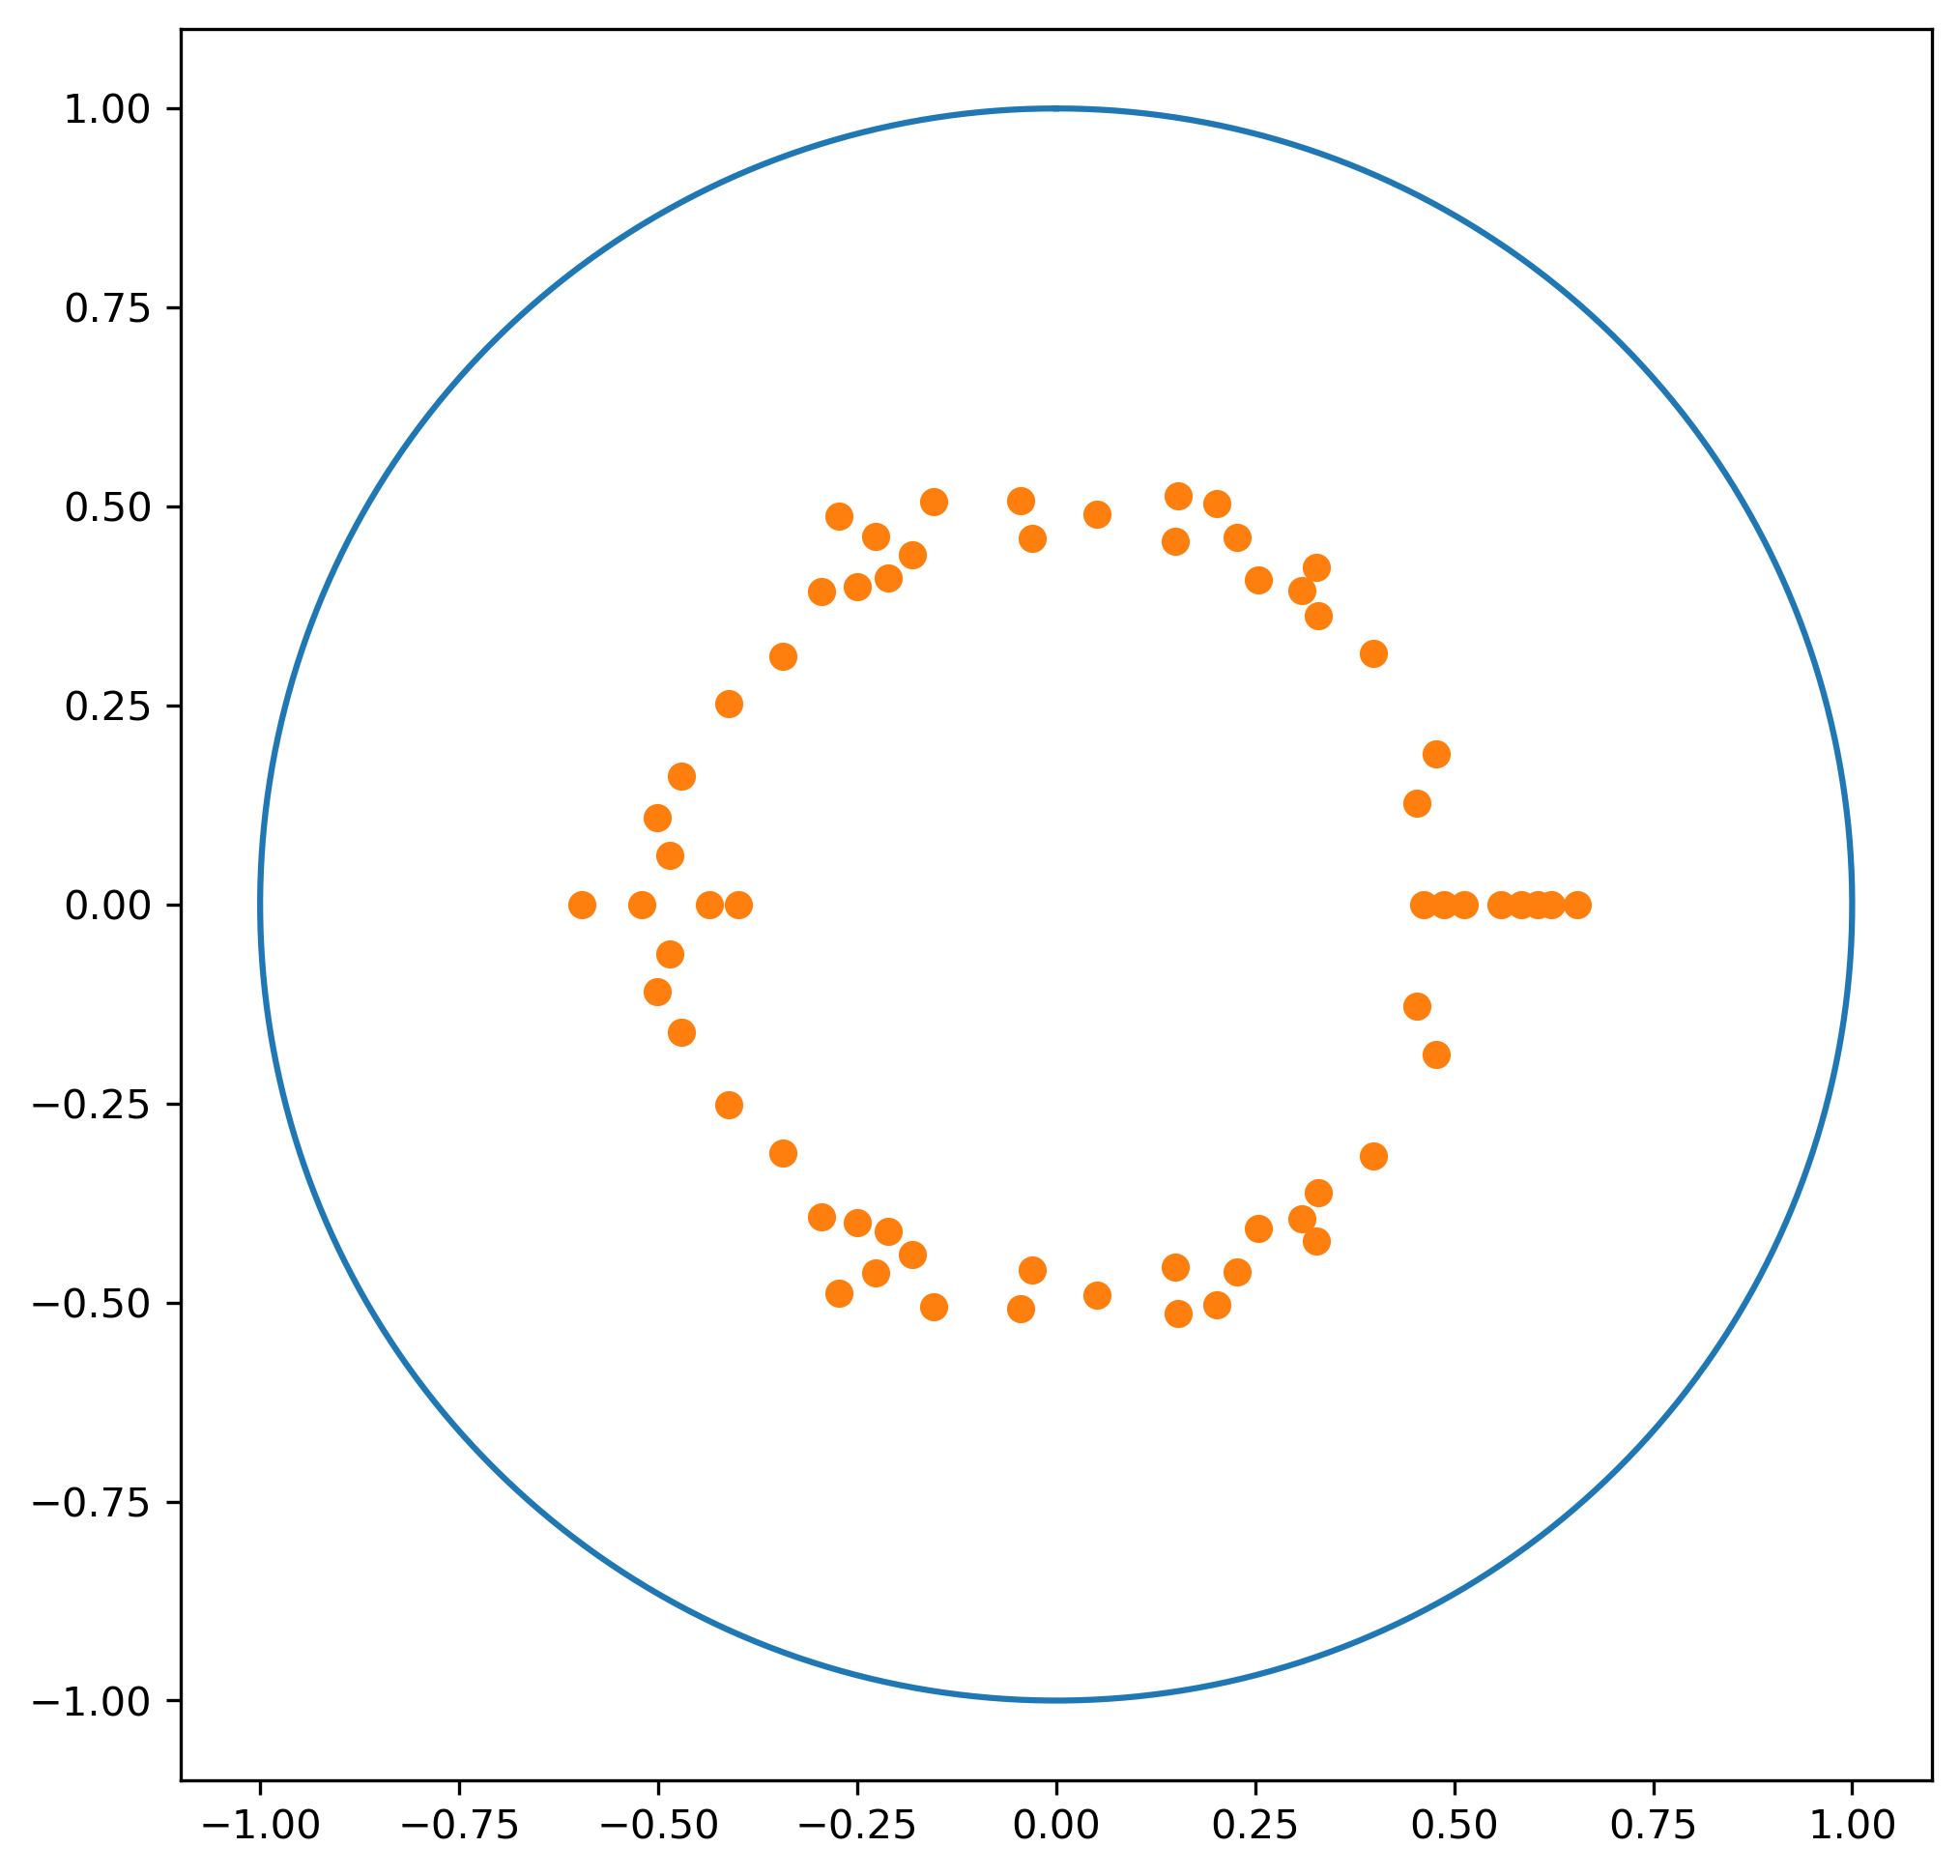

In [12]:
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()